# Training a Classifier on the *Salammbô* Dataset with PyTorch
Author: Pierre Nugues

We use three classes: French, English, and German

We first need to import some modules

In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

### Reading the dataset
We can read the data from a file with the svmlight format or directly create numpy arrays

In [2]:
X = torch.Tensor(
    [[35680, 2217], [42514, 2761], [15162, 990], [35298, 2274],
     [29800, 1865], [40255, 2606], [74532, 4805], [37464, 2396],
     [31030, 1993], [24843, 1627], [36172, 2375], [39552, 2560],
     [72545, 4597], [75352, 4871], [18031, 1119], [36961, 2503],
     [43621, 2992], [15694, 1042], [36231, 2487], [29945, 2014],
     [40588, 2805], [75255, 5062], [37709, 2643], [30899, 2126],
     [25486, 1784], [37497, 2641], [40398, 2766], [74105, 5047],
     [76725, 5312], [18317, 1215]
     ])

We add German data and we adjust `y`

In [3]:
X_de = torch.Tensor(
    [[37599, 1771], [44565, 2116], [16156, 715], [37697, 1804],
     [29800, 1865], [42606, 2146], [78242, 3813], [40341, 1955],
     [31030, 1993], [26676, 1346], [39250, 1902], [41780, 2106],
     [72545, 4597], [79195, 3988], [19020, 928]
     ])

X = torch.vstack((X, X_de))

y = torch.LongTensor(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [4]:
random.seed(4321)
torch.manual_seed(4321)

## Scaling the Data
Scaling and normalizing are usually very significant with neural networks. We use sklean transformers. They consist of two main methods: `fit()` and `transform()`.

### Normalizing

In [5]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X)
X_norm[:4]

array([[0.9980751 , 0.06201605],
       [0.99789774, 0.06480679],
       [0.9978751 , 0.06515607],
       [0.9979313 , 0.06428964]], dtype=float32)

### Standardizing

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_norm)
X_scaled[:4]

array([[-0.03115363,  0.09445252],
       [-0.41286394,  0.44232047],
       [-0.46160385,  0.48585886],
       [-0.34065196,  0.37785798]], dtype=float32)

In [7]:
X_scaled = torch.Tensor(X_scaled)
X_scaled[:4]

tensor([[-0.0312,  0.0945],
        [-0.4129,  0.4423],
        [-0.4616,  0.4859],
        [-0.3407,  0.3779]])

## Creating a Model

We create a classifier equivalent to a logistic regression. PyTorch crossentropy loss includes the softmax of the outputs. We do not add an activation in the last layer. 

The outputs are then called, rather improperly, logits. For a clarification on this terrible terminology, see here: https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173 

In [8]:
input_dim = X_scaled.shape[1]

In [9]:
model = nn.Sequential(torch.nn.Linear(input_dim, 3))
model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)

In [10]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[-0.5296,  0.0533],
         [ 0.2212, -0.6555],
         [ 0.1183,  0.2854]], requires_grad=True),
 Parameter containing:
 tensor([-0.2733,  0.6364, -0.0960], requires_grad=True))

Or with one hidden layer

To try the network with one hidden layer, set `complex` to true

In [11]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Fitting the Model

In [12]:
BATCH_SIZE = 4

In [13]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_scaled, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

We fit the model

In [14]:
loss_history = []
model.train()
for epoch in range(200):
    loss_train = 0
    for X_scaled_batch, y_batch in dataloader:
        y_batch_pred = model(X_scaled_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    loss_history += [BATCH_SIZE * loss_train/len(y)]

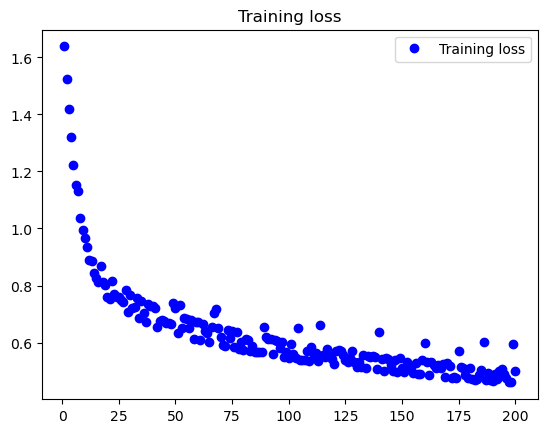

In [15]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

### The weights

In [16]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0561, -0.1914],
                      [-1.6403,  0.9640],
                      [ 1.5064, -1.0894]])),
             ('0.bias', tensor([ 0.7509, -0.6192,  0.1355]))])

## Prediction
### Probabilities

We compute the probabilities to belong to the classes for all the training set

In [17]:
model.eval()

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)

The output with no activation. This is called the logits

In [18]:
with torch.no_grad():
    Y_pred_logits = model(X_scaled)
Y_pred_logits[:4]

tensor([[ 0.7345, -0.4771, -0.0143],
        [ 0.6894,  0.4844, -0.9683],
        [ 0.6838,  0.6063, -1.0892],
        [ 0.6976,  0.3038, -0.7893]])

The probabilities

In [19]:
with torch.no_grad():
    Y_pred_proba = torch.softmax(model(X_scaled), dim=-1)
Y_pred_proba[:4]

tensor([[0.5648, 0.1681, 0.2671],
        [0.4987, 0.4063, 0.0950],
        [0.4772, 0.4417, 0.0811],
        [0.5262, 0.3549, 0.1189]])

We recompute it with matrices

In [20]:
m_params = list(model.parameters())
m_params

[Parameter containing:
 tensor([[-0.0561, -0.1914],
         [-1.6403,  0.9640],
         [ 1.5064, -1.0894]], requires_grad=True),
 Parameter containing:
 tensor([ 0.7509, -0.6192,  0.1355], requires_grad=True)]

In [21]:
torch.softmax(X_scaled @ m_params[0].T + m_params[1], dim=-1)[:4]

tensor([[0.5648, 0.1681, 0.2671],
        [0.4987, 0.4063, 0.0950],
        [0.4772, 0.4417, 0.0811],
        [0.5262, 0.3549, 0.1189]], grad_fn=<SliceBackward0>)

### Classes

In [22]:
y_pred = torch.argmax(Y_pred_proba, dim=-1)
y_pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2])

## Loss
We recompute the loss

For one observation

In [23]:
loss_fn(Y_pred_logits[0], y[0])

tensor(0.5713)

In [24]:
-torch.log(Y_pred_proba[0])[y[0]]

tensor(0.5713)

For the dataset

In [25]:
loss_fn(Y_pred_logits, y)

tensor(0.4552)

In [26]:
-torch.mean(torch.log(Y_pred_proba[range(0, len(y)), y]))

tensor(0.4552)

## Evaluation

With sklearn

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.88        15
           1       0.94      1.00      0.97        15
           2       1.00      0.80      0.89        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



We computed the accuracy from the training set. This is not a good practice. We should use a dedicated test set instead.